# Required Libraries and Tools

In [1]:
# For vector data preparation
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# For raster data preparation
import xarray as xr
import rioxarray

# For PM25 data preparation
import json

# For plotting map
from matplotlib.ticker import MultipleLocator, StrMethodFormatter  #Customize ticks (Optional)
from matplotlib_scalebar.scalebar import ScaleBar                  #Add map scale

# Workflows  and Data Sources
## For PART2 Geopandas
### 1. Prepare background map  
Download world administrative boundaries data from:  
https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?sort=iso3
### 2. Prepare PM2.5 stations data
Download PM2.5 stations and concentrations data from:  
http://air4thai.pcd.go.th/
### 3. Plot map  (vector data only)
<img src="./plot_output/Geopandas_PM25_plot.png" width="500"/>  

## For PART3 Xarray
### 4. Prepare raster data  
Download population density in 2020 data from:  
https://hub.worldpop.org/geodata/summary?id=44120  
Download elevation data from:  
https://srtm.csi.cgiar.org/srtmdata/
### 5. Plot map (add raster data)
<img src="./plot_output/Xarray_PM25_plot.png" width="500"/>   
<img src="./plot_output/Xarray_PopEle_plot.png" width="500"/>  

## 1. Prepare background map  

In [2]:
# Adjust 'data_path' to the actual path where your data files are located
data_path = './data/'
bg = gpd.read_file( data_path + '/asia-administrative-boundaries/cntry_3m.shp' )

In [3]:
# bg.crs                                 #Check crs
# bg['geometry'].geom_type.unique()      #Check geometry type
# (~bg.is_valid).sum()                   #Check invalid geometries

In [4]:
# Change crs
crs = 'EPSG:4326'
bg = bg.to_crs(crs)

In [5]:
# Clip data
xmin, ymin, xmax, ymax = 95, 5, 110, 25    #must be in the same crs
tha = gpd.clip(bg, mask=(xmin, ymin, xmax, ymax), keep_geom_type=False)

## 2. Prepare PM2.5 stations data

### 2.1 Load PM2.5 and stations data

In [6]:
with open("./data/getNewAQI_JSON.json") as f:
    st_data = json.load(f)

In [7]:
# Extract information from json file and build PandasDF
stations = st_data['stations']
col_names = ['stationID', 'areaEN', 'AQILast', 'stationType', 'lat', 'long']
df = pd.DataFrame(stations)[col_names]

In [8]:
# Pull out PM2.5 values from 'AQILast' column
df['PM25'] = df['AQILast'].apply(lambda x: x['PM25']['value'])
df.drop(columns=['AQILast'], inplace=True)

In [9]:
# Change data type
df[df.columns[0:3]] = df[df.columns[0:3]].astype('string')
df[df.columns[3:6]] = df[df.columns[3:6]].astype('float')

In [10]:
# Pull out province data
df['Province'] = df['areaEN'].str.split(', ').str[-1].astype('string')

In [11]:
df[df['Province'] == 'Bangkok'].describe()

,lat,long,PM25
count,82.000000,82.000000,82.000000
mean,13.754050,100.559796,38.682927
std,0.064430,0.103820,6.453783
min,13.636514,100.343164,14.000000
25%,13.707839,100.497658,35.000000
50%,13.751269,100.548084,39.000000
75%,13.784797,100.614569,43.000000
max,13.928868,100.862670,53.000000


### 2.2 Convert PandasDataFrame to GeoDataFrame

In [12]:
geometry = gpd.points_from_xy(df['long'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

## 3. Plot map

In [13]:
def set_ticks_label(ax, tick_interval, tick_size):
    '''
    Set the interval and format for the major ticks on both x and y axes, and adjust the label size.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object to apply the settings to.
    tick_interval (float): The interval between major ticks.
    label_size (int): The size of the tick labels.
    
    '''
    ax.xaxis.set_major_locator(MultipleLocator(tick_interval)) 
    ax.yaxis.set_major_locator(MultipleLocator(tick_interval))
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}°E'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}°N'))
    ax.tick_params(axis='both', labelsize=tick_size)

In [14]:
# Add color code to GeoDF
tha_filt = (tha['CNTRY_NAME'] == 'Thailand')
tha['color_code'] = 'lightgrey'
tha_idx = tha[tha_filt].index
tha.loc[tha_idx, 'color_code'] = 'skyblue'

### 3.1 PM2.5 stations (Solid color)

In [15]:
# Define plot parameters (Adjust values as you like)
# For base map
bg_linewidth = 0.5
bg_edgecolor = 'white'
tick_interval = 5
tick_size = 10

# For PM2.5 stations
pm_linewidth = 0.5
pm_edgecolor = 'black'
pm_marker = 30
pm_st_color = 'red'

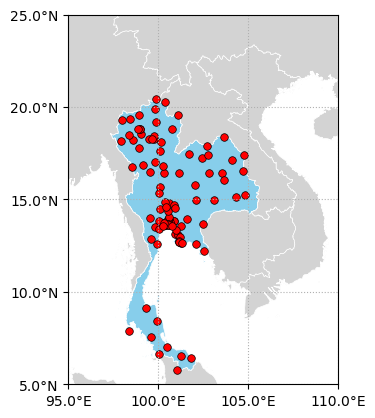

In [16]:
# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
gdf.plot(
        ax=ax_bg, 
        color=pm_st_color, 
        markersize=pm_marker, 
        edgecolor=pm_edgecolor, 
        linewidth=pm_linewidth
)

# Customize Main axis
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

### 3.2 PM2.5 stations (Gradient color)

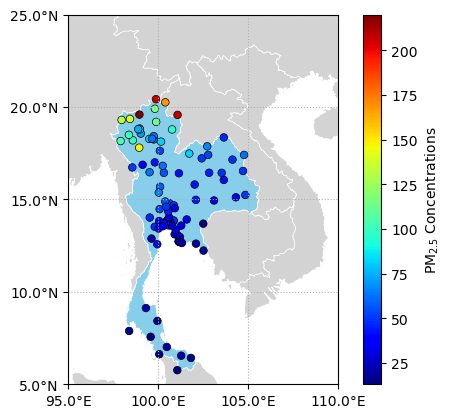

In [17]:
# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
gdf.plot(ax=ax_bg, 
         column='PM25', 
         cmap='jet', 
         legend=True, 
         legend_kwds={'label': 'PM$_{2.5}$ Concentrations'},
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize Main axis
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

Customize colorbar

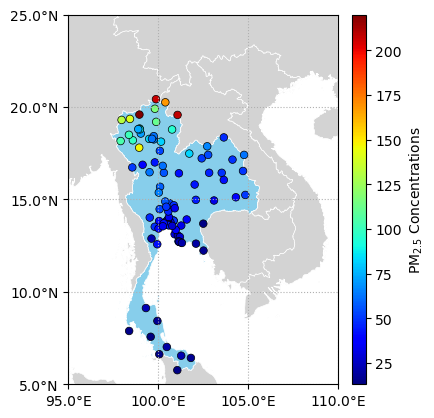

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
divider = make_axes_locatable(ax_bg)
cax = divider.append_axes('right', size="5%", pad=0.1)

gdf.plot(ax=ax_bg, 
         column='PM25', 
         cmap='jet', 
         cax=cax,
         legend=True, 
         legend_kwds={'label': 'PM$_{2.5}$ Concentrations'},
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize Main axis
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

### 3.3 Plot with zoom box

In [19]:
# Define zoom box parameters (Adjust values as you like)
xmin_zb, ymin_zb, xmax_zb, ymax_zb = 99, 12.5, 102, 15
x0, y0, w, h = 1.6, 0.4, 0.8, 0.8 
zb_tick_interval = 1
zb_tick_size = 10

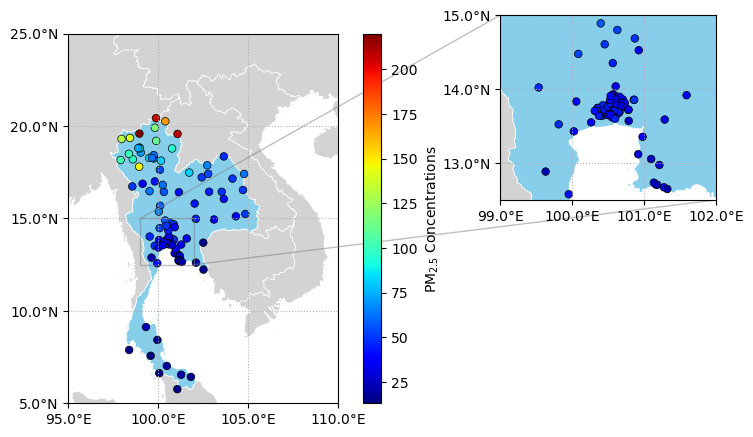

In [20]:
# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
gdf.plot(ax=ax_bg, 
         column='PM25', 
         cmap='jet', 
         legend=True, 
         legend_kwds={'label': 'PM$_{2.5}$ Concentrations'},
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize Main axis
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

# Plot zoom box
ax_zb = ax_bg.inset_axes([x0, y0, w, h])
tha.plot(ax=ax_zb, 
         color=tha['color_code'], 
         edgecolor=bg_edgecolor, 
         linewidth=bg_linewidth
)
gdf.plot(ax=ax_zb, 
         column='PM25', 
         cmap='jet', 
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize zoom box
ax_zb.set(xlim=(xmin_zb, xmax_zb), ylim=(ymin_zb, ymax_zb))
set_ticks_label(ax_zb, zb_tick_interval, zb_tick_size)
ax_zb.grid(True, linestyle='dotted')

#Draw lines between an inset axes and the main axes 
ax_bg.indicate_inset_zoom(ax_zb);

### 3.4 Add important elements

#### 3.4.1 Map scale  
ref: https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html

In [21]:
points = gpd.GeoSeries(
    [Point(105, 20), Point(106, 20)], crs=crs
) 
points = points.to_crs('EPSG:3857') 
distance_meters = points[0].distance(points[1])
distance_meters

111319.49079327285

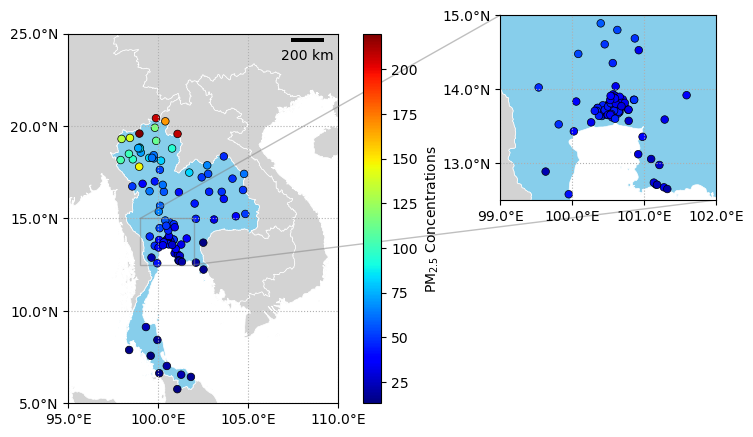

In [22]:
# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
gdf.plot(ax=ax_bg, 
         column='PM25', 
         cmap='jet', 
         legend=True, 
         legend_kwds={'label': 'PM$_{2.5}$ Concentrations'},
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Add scale bar
ax_bg.add_artist(ScaleBar(distance_meters, box_alpha=0))

# Customize Main axis
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

# Plot zoom box
ax_zb = ax_bg.inset_axes([x0, y0, w, h])
tha.plot(ax=ax_zb, 
         color=tha['color_code'], 
         edgecolor=bg_edgecolor, 
         linewidth=bg_linewidth
)
gdf.plot(ax=ax_zb, 
         column='PM25', 
         cmap='jet', 
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize zoom box
ax_zb.set(xlim=(xmin_zb, xmax_zb), ylim=(ymin_zb, ymax_zb))
set_ticks_label(ax_zb, zb_tick_interval, zb_tick_size)
ax_zb.grid(True, linestyle='dotted')

#Draw lines between an inset axes and the main axes 
ax_bg.indicate_inset_zoom(ax_zb);

#### 3.4.2 North arrow  
ref: https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map

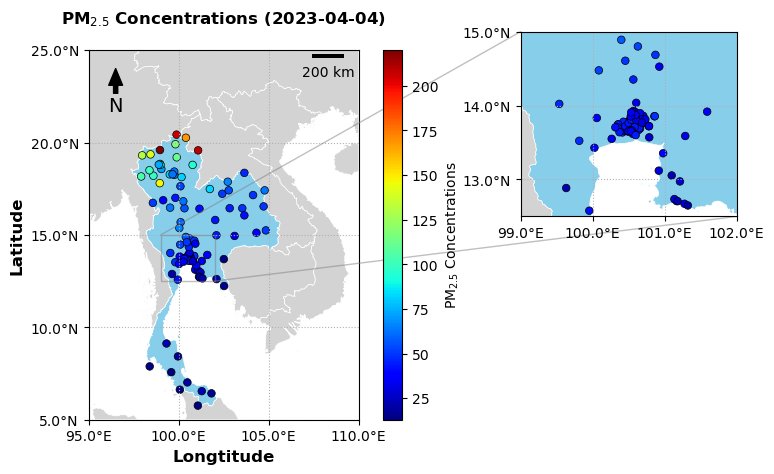

In [23]:
# Plot base map (Main axis)
ax_bg = tha.plot(
                color=tha['color_code'], 
                edgecolor=bg_edgecolor, 
                linewidth=bg_linewidth
)

# Plot PM2.5 stations
gdf.plot(ax=ax_bg, 
         column='PM25', 
         cmap='jet', 
         legend=True, 
         legend_kwds={'label': 'PM$_{2.5}$ Concentrations'},
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Add scale bar
ax_bg.add_artist(ScaleBar(distance_meters, box_alpha=0))

# Add north arrow
x, y, arrow_length = 0.1, 0.95, 0.1 
ax_bg.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=14,
            xycoords=ax_bg.transAxes);

# Customize Main axis
ax_bg.set_title('PM$_{2.5}$ Concentrations (2023-04-04)', fontweight='bold', fontsize=12)
ax_bg.set_ylabel('Latitude', fontweight='bold', fontsize=12)
ax_bg.set_xlabel('Longtitude', fontweight='bold', fontsize=12)
ax_bg.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
set_ticks_label(ax_bg, tick_interval, tick_size)
ax_bg.grid(True, linestyle='dotted')

# Plot zoom box
ax_zb = ax_bg.inset_axes([x0, y0, w, h])
tha.plot(ax=ax_zb, 
         color=tha['color_code'], 
         edgecolor=bg_edgecolor, 
         linewidth=bg_linewidth
)
gdf.plot(ax=ax_zb, 
         column='PM25', 
         cmap='jet', 
         markersize=pm_marker, 
         edgecolor=pm_edgecolor, 
         linewidth=pm_linewidth
)

# Customize zoom box
ax_zb.set(xlim=(xmin_zb, xmax_zb), ylim=(ymin_zb, ymax_zb))
set_ticks_label(ax_zb, zb_tick_interval, zb_tick_size)
ax_zb.grid(True, linestyle='dotted')

#Draw lines between an inset axes and the main axes 
ax_bg.indicate_inset_zoom(ax_zb);

### Save Geopandas plot

In [24]:
out_path = 'path_to_your_output_folder/'
fig = ax_bg.get_figure()
# fig.savefig(out_path + 'file_name.png', dpi=300, bbox_inches='tight');